<a href="https://colab.research.google.com/github/tungnhitran/VAE-Anomaly-Detection-in-Predictive-Maintenance/blob/main/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
 
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
TRAIN_PATH = 'dry run.csv'
TEST_PATH = 'test_data.csv'

In [ ]:
df_base = pd.read_csv(TRAIN_PATH, sep=',')
cols = df_base.columns
cols
del df_base['time']

df_anomaly = pd.read_csv(TEST_PATH, sep=',')
del df_anomaly['time']
df_base.head()


,ax,ay,az,aT
0,-0.3246,0.2748,0.1502,0.451
1,0.6020,-0.1900,-0.3227,0.709
2,0.9787,0.3258,0.0124,1.032
3,0.6141,-0.4179,0.0471,0.744
4,-0.3218,-0.6389,-0.4259,0.833


## Build Data Loader

In [ ]:
def load_and_standardize_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

In [ ]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(TRAIN_PATH)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [ ]:
traindata_set=DataBuilder(TRAIN_PATH, train=True)
testdata_set=DataBuilder(TRAIN_PATH, train=False)
anomalydata_set=DataBuilder(TEST_PATH,train=True)

trainloader=DataLoader(dataset=traindata_set,batch_size=128)
testloader=DataLoader(dataset=testdata_set,batch_size=128)
anomalyloader=DataLoader(anomalydata_set,batch_size=128)

In [ ]:
type(trainloader.dataset.x), type(testloader.dataset.x)

(torch.Tensor, torch.Tensor)

In [ ]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([4622, 5]), torch.Size([1982, 5]))

In [ ]:
trainloader.dataset.x

tensor([[ 0.3910,  1.0411,  1.1225,  1.4695,  0.7925],
        [ 0.1313,  1.1235,  0.9828,  0.5512, -0.2227],
        [ 0.3081, -0.1503, -0.3431, -0.2122, -1.4265],
        ...,
        [ 0.9999,  0.7574, -0.1963, -0.0993, -1.2231],
        [ 1.0849,  0.2104, -0.7661, -0.3276, -0.8934],
        [-1.2956,  0.8494,  0.8129,  1.1837,  0.1546]])

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H,H2,latent_dim=2):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

If you want to better understand the variational autoencoder technique, look [here](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

For better understanding this AutoencoderClass, let me go briefly through it. This is a variational autoencoder (VAE) with two hidden layers, which (by default, but you can change this) 50 and then 12 activations. The latent factors are set to 3 (you can change that, too). So we're first exploding our initially 14 variables to 50 activations, then condensing it to 12, then to 3. From these 3 latent factors we then sample to recreate the original 14 values. We do that by inflating the 3 latent factors back to 12, then 50 and finally 14 activations (we decode the latent factors so to speak). With this reconstructed batch (recon_batch) we compare it with the original batch, computate our loss and adjust the weights and biases via our gradient (our optimizer here will be Adam). 

In [ ]:
D_in = traindata_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_mse = customLoss()

## Train Model

In [ ]:
epochs = 200
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 20 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [ ]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 20 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 20 Average training loss: 4.2282
====> Epoch: 20 Average test loss: 0.2645
====> Epoch: 20 Average test loss: 0.5376
====> Epoch: 20 Average test loss: 0.8357
====> Epoch: 20 Average test loss: 1.1030
====> Epoch: 20 Average test loss: 1.3604
====> Epoch: 20 Average test loss: 1.6524
====> Epoch: 20 Average test loss: 1.9190
====> Epoch: 20 Average test loss: 2.1814
====> Epoch: 20 Average test loss: 2.4366
====> Epoch: 20 Average test loss: 2.7002
====> Epoch: 20 Average test loss: 2.9550
====> Epoch: 20 Average test loss: 3.2269
====> Epoch: 20 Average test loss: 3.5018
====> Epoch: 20 Average test loss: 3.7850
====> Epoch: 20 Average test loss: 4.0663
====> Epoch: 20 Average test loss: 4.1936
====> Epoch: 40 Average training loss: 3.8604
====> Epoch: 40 Average test loss: 0.2373
====> Epoch: 40 Average test loss: 0.4840
====> Epoch: 40 Average test loss: 0.7492
====> Epoch: 40 Average test loss: 0.9928
====> Epoch: 40 Average test loss: 1.2262
====> Epoch: 40 Average te

In [ ]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [ ]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy())
real_row = scaler.inverse_transform(testloader.dataset.x[0].cpu().numpy())
print(real_row)

[14.843   0.4923  1.033   0.1377  1.153 ]


In [ ]:
df = pd.DataFrame(np.stack((recon_row, real_row)), columns = cols)
df

,time,ax,ay,az,aT
0,29.998652,0.087614,0.029141,-0.067593,0.788637
1,14.843000,0.492300,1.033000,0.137700,1.153000


In [ ]:
sigma = torch.exp(logvar/2)

In [ ]:
mu[1], sigma[1]

(tensor([ 0.0077, -1.2706], device='cuda:0'),
 tensor([0.9993, 0.3363], device='cuda:0'))

In [ ]:
mu.mean(axis=0), sigma.mean(axis=0)

(tensor([0.0007, 0.0092], device='cuda:0'),
 tensor([0.9990, 0.3566], device='cuda:0'))

In [ ]:
# sample z from q
no_samples = traindata_set.x.shape[0]
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))
print(no_samples)

4622


In [ ]:
z.shape

torch.Size([4622, 2])

In [ ]:
z[:5]

tensor([[ 1.6702,  0.1200],
        [-0.4516,  0.1900],
        [ 0.4871,  0.0086],
        [-2.1263,  0.2678],
        [-0.3308, -0.3156]], device='cuda:0')

In [ ]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

In [ ]:
pred[1]

array([-0.09934235,  0.5321117 ,  0.64761573,  0.20795664, -0.34611413],
      dtype=float32)

In [ ]:
fake_data = scaler.inverse_transform(pred)
fake_data.shape

(4622, 5)

In [ ]:
df_fake = pd.DataFrame(fake_data, columns = cols)
df_fake['time'] = np.round(df_fake['time']).astype(int)
#df_fake['time'] = np.where(df_fake['time']<1, 1, df_fake['time'])
print(df_fake)
df_fake.to_csv('fake.csv')

      time        ax        ay        az        aT
0       31  0.197441  0.238622  0.014365  0.912715
1       31  0.338270  0.523044  0.106282  1.071723
2       30  0.061207 -0.015579 -0.079240  0.823674
3       33  0.436639  0.688422  0.207337  1.202315
4       35 -0.465837 -0.615207 -0.673676  1.263743
...    ...       ...       ...       ...       ...
4617    36  0.582693  0.883618  0.473752  1.490480
4618    31  0.024764 -0.040416 -0.146738  0.834721
4619    36  0.583659  0.548244  1.390502  1.977449
4620    31 -0.013189 -0.134117 -0.139786  0.834939
4621    31  0.107516  0.094563 -0.074430  0.865624

[4622 rows x 5 columns]


For comparison the real data:

In [ ]:
#generate from anomaly data
with torch.no_grad():
    for batch_idx, data in enumerate(anomalyloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

scaler = anomalyloader.dataset.standardizer
recon_test_row = scaler.inverse_transform(recon_batch[0].cpu().numpy())
sigma = torch.exp(logvar/2)

no_samples_test = df_anomaly.shape[0]
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples_test]))
print(no_samples_test)

29224


In [ ]:
z.shape

torch.Size([29224, 2])

In [ ]:
with torch.no_grad():
    pred_test = model.decode(z).cpu().numpy()
fake_data_test = scaler.inverse_transform(pred_test)

df_fake_test = pd.DataFrame(fake_data_test, columns = cols)
df_fake_test['time'] = np.round(df_fake_test['time']).astype(int)
#df_fake_test['time'] = np.where(df_fake_test['time']<1, 1, df_fake_test['time'])
del df_fake_test['time']
print(df_fake_test)

             ax        ay        az        aT
0      0.575444  0.110038  3.175564  3.346946
1      0.391271  0.609004  0.151937  1.133889
2     -0.212289 -0.406150 -0.342882  0.961295
3     -0.092752 -0.197173 -0.293937  0.935848
4     -0.011454 -0.103941 -0.182523  0.840272
...         ...       ...       ...       ...
29219 -0.251613 -0.448805 -0.388939  0.986673
29220 -0.836800 -0.855298 -1.209944  1.848542
29221  0.017254 -0.063133 -0.146929  0.834483
29222  0.114969  0.104149 -0.072868  0.871952
29223  0.546512  0.185186  2.584267  2.840847

[29224 rows x 4 columns]


In [ ]:
#reconstruction error test data
#del df_fake_test['time']
mse_test = ((df_anomaly-df_fake_test)**2).max(axis=1)
print(mse_test)
mse_test.to_csv('mse_test.csv')

0        11.727641
1         1.321036
2         0.474559
3         0.347660
4         0.370085
           ...    
29219     1.344641
29220    16.899041
29221     2.616361
29222     2.532717
29223    20.238901
Length: 29224, dtype: float64


In [ ]:
#reconstruction error train data
#del df_base['time']
#del df_fake['time']
mse = ((df_base[0:4622]-df_fake)**2).mean(axis=1)
print(mse)
mse.to_csv('mse.csv')

0       0.126367
1       0.223395
2       0.252533
3       0.372792
4       0.067060
          ...   
4617    1.055836
4618    0.854574
4619    1.464029
4620    3.105731
4621    0.214447
Length: 4622, dtype: float64


In [ ]:
#threshold = np.quantile(mse,0.9)
threshold = mse.mean()
print(threshold)

0.916231494643133


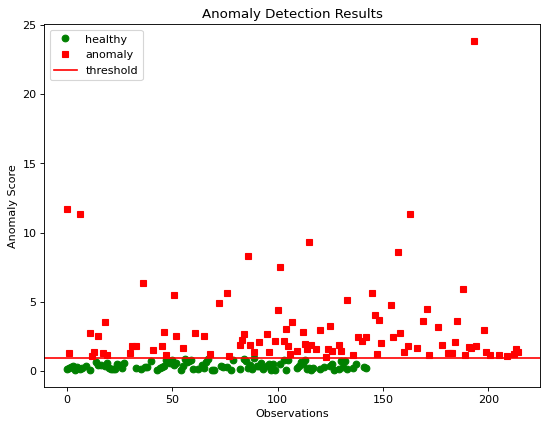

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(mse[0:100],'go',label='healthy')
plt.plot(mse_test[0:100],'rs',label='anomaly')
plt.axhline(y=threshold,color='r', linestyle='-',label='threshold')
plt.legend()
plt.xlabel("Observations")
plt.ylabel("Anomaly Score")
plt.title('Anomaly Detection Results')
plt.savefig('AD.pdf')
plt.show()
